In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Plot Each Row ----------
for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    # Get valid indices (not NaN)
    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 4:
        print(f"Skipping row {idx} at (Lat, Lon) = ({lat}, {lon}) due to insufficient data.")
        continue

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    # Convert datetime to days for interpolation
    x = (valid_dates - valid_dates[0]).days
    x_all = (date_times - valid_dates[0]).days

    # Apply PCHIP interpolation
    interp = PchipInterpolator(x, valid_values)
    y_interp = interp(x_all)

    # Only consider plotting between the first and last valid points
    first_valid_idx = valid_mask.argmax()
    last_valid_idx = len(valid_mask) - np.argmax(valid_mask[::-1])

    plot_dates = date_times[first_valid_idx:last_valid_idx]
    plot_values = y_interp[first_valid_idx:last_valid_idx]

    # Set y-axis limits dynamically per plot
    local_min = np.min(plot_values)
    local_max = np.max(plot_values)
    padding = (local_max - local_min) * 0.1
    ymin = local_min - padding
    ymax = local_max + padding

    # ---------- Step 3: Plot ----------
    plt.figure(figsize=(14, 5))
    plt.plot(plot_dates, plot_values, label='PCHIP Interpolation', color='blue')
    plt.scatter(valid_dates, valid_values, label='Original Data', color='red')
    plt.title(f'PCHIP Interpolation for (Lat: {lat}, Lon: {lon})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.ylim(ymin, ymax)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)

    plt.show()


In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Compute Metrics ----------
results = []

for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 6:
        continue  # Skip rows with too few data points

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    total_points = len(valid_values)
    split_idx = int(total_points * 0.8)

    train_dates = valid_dates[:split_idx]
    train_values = valid_values[:split_idx]
    test_dates = valid_dates[split_idx:]
    test_values = valid_values[split_idx:]

    if len(test_values) < 2:
        continue

    # Convert to days
    x_train = (train_dates - train_dates[0]).days
    x_test = (test_dates - train_dates[0]).days

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            interp = PchipInterpolator(x_train, train_values)
            y_pred = interp(x_test)

        # Calculate metrics
        mae = mean_absolute_error(test_values, y_pred)
        rmse = mean_squared_error(test_values, y_pred, squared=False)
        r2 = r2_score(test_values, y_pred)

        results.append({
            'Index': idx,
            'Lat': lat,
            'Lon': lon,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

    except Exception:
        continue  # Silently skip errors

# ---------- Step 3: Output Metrics ----------
results_df = pd.DataFrame(results)
pd.set_option("display.precision", 4)
print(results_df)



     Index    Lat    Lon        MAE       RMSE          R2
0        0  23.00  74.25     2.1292     2.9412 -1.1012e+00
1        1  23.00  74.50   147.2196   208.7546 -1.4924e+04
2        2  23.25  73.75   110.7885   154.2444 -4.4235e+03
3        3  23.25  74.00     3.9415     4.3719 -4.3421e+00
4        4  23.25  74.25   447.8133   686.0205 -1.1090e+06
..     ...    ...    ...        ...        ...         ...
918    918  32.00  75.25  1562.6524  2421.1962 -3.8728e+06
919    919  32.00  75.50   976.6709  1474.1848 -8.3177e+06
920    920  32.25  75.25     6.0072     8.2526 -9.7682e+01
921    921  32.25  75.50   689.8328  1011.3739 -2.8599e+06
922    922  32.25  75.75     4.4151     4.4737 -1.0426e+02

[923 rows x 6 columns]



Zone-wise Performance Statistics:
                 MAE              RMSE                   R2            
                mean      std     mean      std        mean         std
Zone                                                                   
Central-East  507.16  2064.06   767.13  3043.67 -9.8856e+06  1.2446e+08
Central-West  174.61   479.43   263.31   693.00 -5.9122e+27  8.9858e+28
North-East    660.98  1850.19  1031.58  2779.89 -1.5308e+06  4.6527e+06
North-West    366.13   641.09   583.12  1059.84 -1.0642e+06  2.6392e+06
South-East    348.02   407.06   511.60   599.24 -2.3262e+05  6.6498e+05
South-West    359.46   751.57   540.93  1194.58 -1.1572e+05  2.6756e+05


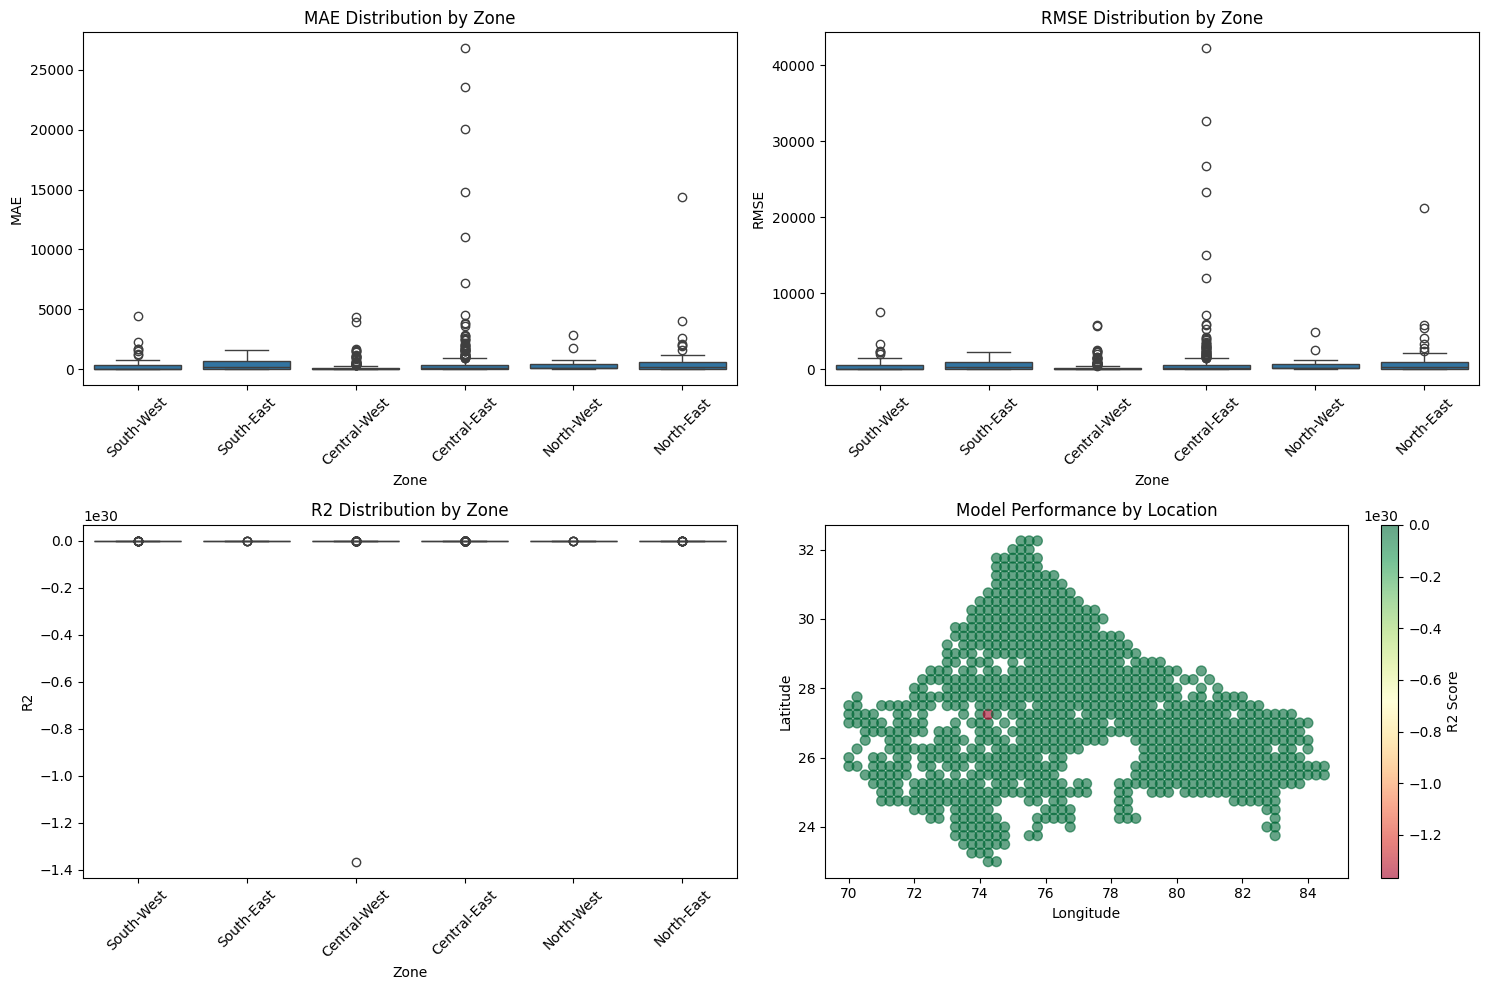


Best Performing Zones (based on R2):
Zone
South-West   -1.1572e+05
South-East   -2.3262e+05
North-West   -1.0642e+06
Name: R2, dtype: float64

Worst Performing Zones (based on R2):
Zone
Central-West   -5.9122e+27
Central-East   -9.8856e+06
North-East     -1.5308e+06
Name: R2, dtype: float64

Number of locations in each zone:
Zone
Central-East    507
Central-West    231
North-East       67
South-West       57
South-East       36
North-West       25
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from previous analysis
results_df = pd.DataFrame(results)

# Define zones based on latitude and longitude ranges
def assign_zone(lat, lon):
    if lat < 25:
        if lon < 75:
            return 'South-West'
        else:
            return 'South-East'
    elif lat < 30:
        if lon < 75:
            return 'Central-West'
        else:
            return 'Central-East'
    else:
        if lon < 75:
            return 'North-West'
        else:
            return 'North-East'

# Add zone column to results
results_df['Zone'] = results_df.apply(lambda x: assign_zone(x['Lat'], x['Lon']), axis=1)

# Calculate zone-wise statistics
zone_stats = results_df.groupby('Zone').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(2)

print("\nZone-wise Performance Statistics:")
print(zone_stats)

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Zone-wise MAE Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(x='Zone', y='MAE', data=results_df)
plt.title('MAE Distribution by Zone')
plt.xticks(rotation=45)

# 2. Zone-wise RMSE Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(x='Zone', y='RMSE', data=results_df)
plt.title('RMSE Distribution by Zone')
plt.xticks(rotation=45)

# 3. Zone-wise R2 Box Plot
plt.subplot(2, 2, 3)
sns.boxplot(x='Zone', y='R2', data=results_df)
plt.title('R2 Distribution by Zone')
plt.xticks(rotation=45)

# 4. Scatter plot of locations colored by R2 score
plt.subplot(2, 2, 4)
scatter = plt.scatter(results_df['Lon'], results_df['Lat'], 
                     c=results_df['R2'], cmap='RdYlGn',
                     s=50, alpha=0.6)
plt.colorbar(scatter, label='R2 Score')
plt.title('Model Performance by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print summary of best and worst performing zones
print("\nBest Performing Zones (based on R2):")
best_zones = results_df.groupby('Zone')['R2'].mean().sort_values(ascending=False)
print(best_zones.head(3))

print("\nWorst Performing Zones (based on R2):")
worst_zones = results_df.groupby('Zone')['R2'].mean().sort_values()
print(worst_zones.head(3))

# Additional analysis: Count of locations in each zone
zone_counts = results_df['Zone'].value_counts()
print("\nNumber of locations in each zone:")
print(zone_counts)